# KNN-CF Recommender Engine
### This notebook contians the recommender engine using the KNN Collaborative Filtering model.

### Preprocessing and preliminary code:

Libraries used in preprocessing and data manipulation:

In [149]:
import numpy as np 
import pandas as pd

# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [150]:
#To set up the engine we will start with the Movielens 100k
movie_100k = pd.read_csv('data\movielens_100k\movies.csv')
rating_100k = pd.read_csv('data\\movielens_100k\\ratings.csv')
print("Original data columns:")
print(movie_100k.columns)
print(rating_100k.columns)

#We create new dataframes only using the columns that are necessary
movies = movie_100k.loc[:,["movieId","title"]]
ratings = rating_100k.loc[:,["userId","movieId","rating"]]

print("\n\n\nTruncated dataframes;")
print(movies.columns)
print(ratings.columns)

#This command creates a dataframe which merges both ratings and movies based on a common column (movieId)
data_100k = pd.merge(movies,ratings)

Original data columns:
Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')



Truncated dataframes;
Index(['movieId', 'title'], dtype='object')
Index(['userId', 'movieId', 'rating'], dtype='object')


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Dominic\AppData\Local\Temp\ipykernel_10040\1108140883.py:2: SyntaxWarning: invalid escape sequence '\m'
  movie_100k = pd.read_csv('data\movielens_100k\movies.csv')


In [151]:
#This method performs all preprocessing that is required for the data before using the KNN algorithm
#It takes in a dataset in the form of a dataframe, a index_column_name for specifying by which column in the dataframe we filter by value counts, and a threshold which determines the point at which 
#we stop considering the data in the indexed column by how many times they appear in the dataset.
def preprocess(data, index_column_name, threshold):
    
    #filtering out instances which do not appear more than the threshold in the dataframe
    index_counts = data_100k[index_column_name].value_counts().sort_values(ascending=False)
    filtered_counts = index_counts[index_counts >= threshold]
    pre_processed_data = data_100k[data_100k[index_column_name].isin(filtered_counts.index)]
    
    
    
    return pre_processed_data


We will now try to create a matrix which maps all user ratings to all movies (for each movie (row) we will have each user (column) and their ratings)

In [152]:
data_100k_filtered = preprocess(data_100k, 'movieId', 150)
print("Data shape before preprocessing:")
print(data_100k.shape)
print("Data shape after preprocessing:")
print(data_100k_filtered.shape)
print("\n")


user_movie_table = data_100k_filtered.pivot_table(index=["title"], columns=["userId"], values="rating").fillna(0)
print("Pivot table visualization:")    
user_movie_table.head(10)

Data shape before preprocessing:
(100836, 4)
Data shape after preprocessing:
(8784, 4)


Pivot table visualization:


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: Pet Detective (1994),0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,0.0,3.0
Aladdin (1992),0.0,0.0,0.0,4.0,4.0,5.0,3.0,0.0,0.0,4.0,...,0.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,0.0,0.0
American Beauty (1999),5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,5.0,0.0,0.0,4.5,3.0,5.0,0.0,3.5
Apollo 13 (1995),0.0,0.0,0.0,0.0,3.0,4.0,4.5,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,5.0,0.0,5.0,2.0,3.0,0.0
Back to the Future (1985),5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,0.0,0.0,2.0,0.0,4.0,3.5,3.0,2.0,0.0,5.0
Batman (1989),4.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,...,0.0,4.0,2.0,4.0,3.0,3.5,3.0,3.0,3.0,4.5
Braveheart (1995),4.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,0.0,...,0.0,5.0,1.0,3.0,3.0,3.5,5.0,4.0,3.0,4.5
Dances with Wolves (1990),4.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,0.0,...,0.0,3.0,3.0,0.0,3.0,4.0,0.0,3.0,4.0,0.0
Fargo (1996),5.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,4.5


For the code above I will provide chatGPTs explanation of the methods bc I couldn't explain it better and i dont care to at the moment:

*Here, the pivot_table function is used to reshape the data dataframe. Let's understand the parameters:*

- *index=["title"]: This sets the "title" column as the index of the pivot table. Each unique movie title will become a row in the pivot table.*
- *columns=["userId"]: This sets the "userId" column as the columns of the pivot table. Each unique user ID will become a column in the pivot table.*
- *values="rating": This specifies that the values to be filled in the pivot table come from the "rating" column of the data dataframe.*
- *fillna(0): This fills any missing (NaN) values in the pivot table with 0.*

*As a result, user_movie_table becomes a matrix where rows represent movies, columns represent users, and the cells contain ratings given by users to movies. Any missing ratings are filled with 0, indicating no rating was given.*

### KNN Engine implemented 


Below I use our previous matrix to implement a basic KNN Recommender using the Sklearn NearestNeighbors library implementation. To show an example of the implementation I pick a random user and print the 5 nearest 

In [153]:
query_index = np.random.choice(user_movie_table.shape[0])

k_value = 6

user_movie_table_matrix = csr_matrix(user_movie_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = k_value+1)
indices = indices[0][1:]

print("Random movie: \"" + str(user_movie_table.index[query_index]) + "\"'s closest " + str(k_value) + " neighbors are:")
j = 0
for i, index in enumerate(indices):
    print("\tRecommendation " + str(i + 1) + "\tMovie: " + str(user_movie_table.index[index]) + ", Distance: " + str(distances[0][i]))

Random movie: "Godfather, The (1972)"'s closest 6 neighbors are:
	Recommendation 1	Movie: Star Wars: Episode IV - A New Hope (1977), Distance: 8.881784197001252e-16
	Recommendation 2	Movie: Fargo (1996), Distance: 0.4046831966011223
	Recommendation 3	Movie: Star Wars: Episode V - The Empire Strikes Back (1980), Distance: 0.41138570937939367
	Recommendation 4	Movie: Fight Club (1999), Distance: 0.41396973485757593
	Recommendation 5	Movie: Pulp Fiction (1994), Distance: 0.4187209955115919
	Recommendation 6	Movie: American Beauty (1999), Distance: 0.4247295981946636


## Visualizations

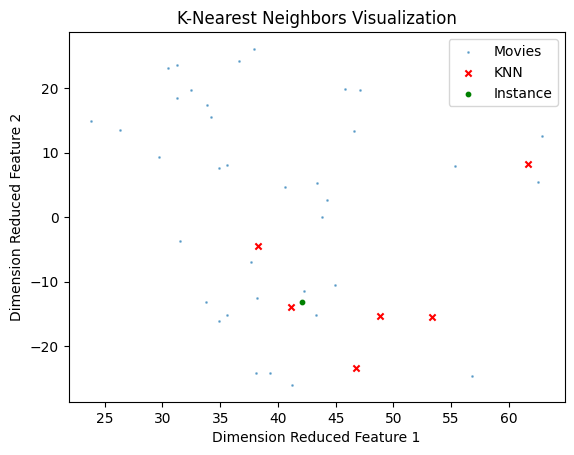

In [154]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Assuming user_movie_table_matrix is your sparse user-movie matrix
X = user_movie_table_matrix

# Perform TruncatedSVD to reduce data to 2 dimensions (or any number of dimensions you desire)
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

# Plot all data points
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], label='Movies', alpha=0.5, s=1)

# Plot k-nearest neighbors of a specific point (query_index)
plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], c='red', label='KNN', marker='x', s=20)

plt.scatter(X_reduced[query_index, 0], X_reduced[query_index, 1], c='Green', label='Instance', marker='o', s=10, alpha=1)

plt.legend()
plt.xlabel('Dimension Reduced Feature 1')
plt.ylabel('Dimension Reduced Feature 2')
plt.title('K-Nearest Neighbors Visualization')





plt.show()


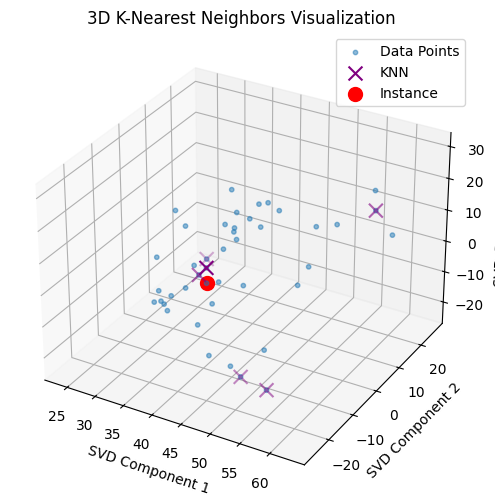

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD

# Assuming user_movie_table_matrix is your sparse user-movie matrix
X = user_movie_table_matrix

# Perform TruncatedSVD to reduce data to 3 dimensions
svd = TruncatedSVD(n_components=3)
X_reduced = svd.fit_transform(X)

# Assuming indices are defined (indices of k-nearest neighbors)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Specify 3D projection

# Plot all data points (set marker size to 50)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], label='Data Points', alpha=0.5, s=10)

# Plot k-nearest neighbors of a specific point (query_index) with a different marker size (e.g., 100)
ax.scatter(X_reduced[indices, 0], X_reduced[indices, 1], X_reduced[indices, 2], c='purple', label='KNN', marker='x', s=100)

ax.scatter(X_reduced[query_index, 0], X_reduced[query_index, 1], X_reduced[query_index, 2], c='red', label='Instance', marker='o', s=100, alpha=1)

ax.set_xlabel('SVD Component 1')
ax.set_ylabel('SVD Component 2')
ax.set_zlabel('SVD Component 3')
ax.set_title('3D K-Nearest Neighbors Visualization')
ax.legend()
# # Set specific limits for each axis to zoom in
# lim = 3
# ax.set_xlim(-lim, lim)  # Specify the minimum and maximum values for the x-axis
# ax.set_ylim(-lim, lim)  # Specify the minimum and maximum values for the y-axis
# ax.set_zlim(-lim, lim)  # Specify the minimum and maximum values for the z-axis


plt.show()
